In [1]:
import os
import uuid
import zipfile
from os.path import join, dirname
from tempfile import gettempdir
from unittest import TestCase
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from aequilibrae import TrafficAssignment, TrafficClass, Graph, Project, ODME
from tests.data import siouxfalls_project

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Set up data:
os.environ["PATH"] = os.path.join(gettempdir(), "temp_data") + ";" + os.environ["PATH"]
proj_path = os.path.join(gettempdir(), "test_odme_files" + uuid.uuid4().hex)
os.mkdir(proj_path)
zipfile.ZipFile(join(dirname(siouxfalls_project), "sioux_falls_single_class.zip")).extractall(proj_path)

# Initialise project:
project = Project()
project.open(proj_path)
project.network.build_graphs()
car_graph = project.network.graphs["c"]  # type: Graph

car_graph.set_graph("free_flow_time")
car_graph.set_blocked_centroid_flows(False)
matrix = project.matrices.get_matrix("demand_omx")
matrix.computational_view()

# Extra data specific to ODME:
index = car_graph.nodes_to_indices
dims = matrix.matrix_view.shape
count_vol_cols = ["class", "link_id", "direction", "obs_volume"]
# Still need to add mode/class name to these!!!

# Initial assignment parameters:
assignment = TrafficAssignment()
assignclass = TrafficClass("car", car_graph, matrix)
assignment.set_classes([assignclass])
assignment.set_vdf("BPR")
assignment.set_vdf_parameters({"alpha": 0.15, "beta": 4.0})
assignment.set_vdf_parameters({"alpha": "b", "beta": "power"})
assignment.set_capacity_field("capacity")
assignment.set_time_field("free_flow_time")
assignment.max_iter = 5
assignment.set_algorithm("msa")

In [4]:
algorithm = "reg_spiess"

# Get original flows:
assignment.execute()
assign_df = assignment.results().reset_index(drop=False).fillna(0)
# SQUISH EXTRA DIMENSION FOR NOW - DEAL WITH THIS PROPERLY LATER ON!!!
matrix.matrix_view = np.squeeze(matrix.matrix_view, axis=2)

# Set the observed count volumes:
flow = lambda i: assign_df.loc[assign_df["link_id"] == i, "matrix_ab"].values[0]
count_volumes = pd.DataFrame(
    data=[["car", i, 1, flow(i)] for i in assign_df["link_id"]],
    columns=count_vol_cols
)

# Store original matrix
original_demand = np.copy(matrix.matrix_view)

# Perturb original matrix:
np.random.seed(0)
perturbation = 5 # %
perturbation_matrix = np.random.uniform(1 - perturbation/100, 1 + perturbation/100, size=dims)
new_matrix = np.round(matrix.matrix_view * perturbation_matrix)

In [5]:
all_odme = []

for i in range(1, 11):
    matrix.matrix_view = np.copy(new_matrix)

    # Perform ODME:
    all_odme.append(ODME(assignment,
        count_volumes,
        stop_crit=(10, 250, 1000, 50),
        alpha=i/10,
        algorithm=algorithm)
    )
    all_odme[i-1].execute()
    print(f"{i} has finished running.")
cumulative_factors = [odme.get_cumulative_factors() for odme in all_odme]

1 has finished running.
2 has finished running.
3 has finished running.
4 has finished running.
5 has finished running.
6 has finished running.
7 has finished running.
8 has finished running.
9 has finished running.
10 has finished running.


In [6]:
for i in range(1, 11):
    matrix.matrix_view = np.copy(new_matrix)

    # Perform ODME:
    odme = ODME(assignment,
        count_volumes,
        stop_crit=(10, 250, 1000, 50),
        alpha=i/10,
        algorithm=algorithm)
    print(f"{i/10} alpha -> {odme.estimate_alpha(i/10)}")

0.1 alpha -> 0.08442878451502234
0.2 alpha -> 0.14610694221866458
0.3 alpha -> 0.19313836999338124
0.4 alpha -> 0.23018658878731332
0.5 alpha -> 0.2601252621648833
0.6 alpha -> 0.2848217021451337
0.7 alpha -> 0.3055419339816503
0.8 alpha -> 0.32317468737343513
0.9 alpha -> 0.33836220106047776
1.0 alpha -> 0.35158013764061374


In [7]:
cumulative_stats = [data.describe() for data in cumulative_factors]

In [8]:
all_stats = pd.concat(cumulative_stats, axis=1)
all_stats = all_stats.transpose().reset_index(drop=True)
all_stats["alpha"] = (all_stats.index + 1) / 10
all_stats

,count,mean,std,min,25%,50%,75%,max,alpha
0,576.0,0.973440,0.288120,5.316986e-03,0.858587,1.000000,1.077252,2.489699,0.1
1,576.0,0.989329,0.398195,9.655653e-18,0.852067,1.000000,1.093827,4.226716,0.2
2,576.0,0.988221,0.566369,1.026809e-19,0.736252,1.000000,1.169476,4.461492,0.3
3,576.0,0.963666,0.629423,4.575969e-32,0.673232,0.973652,1.146092,5.022086,0.4
4,576.0,1.000047,0.736617,3.010525e-20,0.625064,1.000000,1.186438,6.025433,0.5
5,576.0,1.036868,0.770016,1.481480e-16,0.620102,1.000000,1.247961,6.007856,0.6
6,576.0,1.067456,0.945170,9.823320e-12,0.572744,1.000000,1.308943,8.277713,0.7
7,576.0,1.056391,1.046271,1.838913e-10,0.460648,0.932619,1.304542,8.559640,0.8
8,576.0,1.100411,1.210794,1.871622e-06,0.353141,0.959300,1.368189,15.272876,0.9
9,576.0,1.042180,1.376246,5.435358e-04,0.287134,0.703673,1.245586,20.802761,1.0


<Axes: xlabel='alpha', ylabel='mean'>

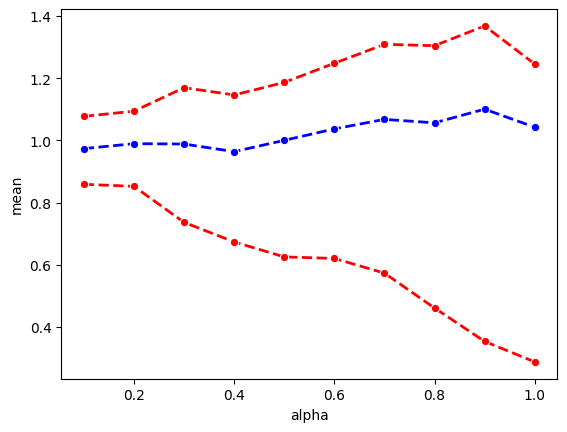

In [9]:
sns.lineplot(x='alpha', y='mean', data=all_stats, marker='o', color='blue', linestyle='--', linewidth=2)
sns.lineplot(x='alpha', y='75%', data=all_stats, marker='o', color='red', linestyle='--', linewidth=2)
sns.lineplot(x='alpha', y='25%', data=all_stats, marker='o', color='red', linestyle='--', linewidth=2)

<Axes: xlabel='alpha', ylabel='std'>

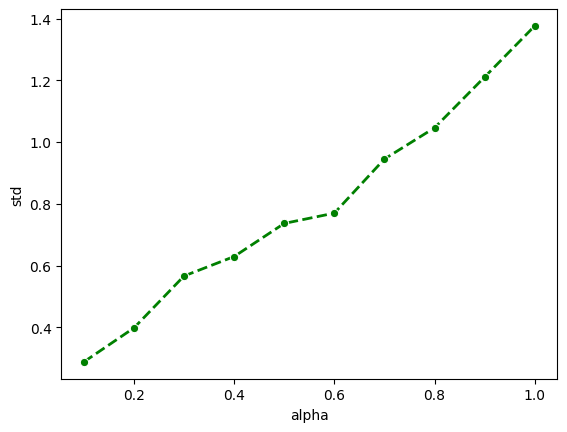

In [10]:
sns.lineplot(x='alpha', y='std', data=all_stats, marker='o', color='green', linestyle='--', linewidth=2)

In [11]:
print(cumulative_stats[2])
print(cumulative_stats[5])
print(cumulative_stats[8])

            Factors
count  5.760000e+02
mean   9.882213e-01
std    5.663694e-01
min    1.026809e-19
25%    7.362521e-01
50%    1.000000e+00
75%    1.169476e+00
max    4.461492e+00
            Factors
count  5.760000e+02
mean   1.036868e+00
std    7.700162e-01
min    1.481480e-16
25%    6.201016e-01
50%    1.000000e+00
75%    1.247961e+00
max    6.007856e+00
          Factors
count  576.000000
mean     1.100411
std      1.210794
min      0.000002
25%      0.353141
50%      0.959300
75%      1.368189
max     15.272876


In [12]:
matrix.matrix_view = np.copy(new_matrix)

# Perform ODME:
odme = ODME(assignment,
    count_volumes,
    stop_crit=(10, 250, 1000, 50),
    alpha=i/10,
    algorithm="spiess")
odme.execute()
spiess_cumulative = odme.get_cumulative_factors()

In [13]:
spiess_cumulative.describe()

,Factors
count,576.000000
mean,1.042180
std,1.376246
min,0.000544
25%,0.287134
50%,0.703673
75%,1.245586
max,20.802761


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


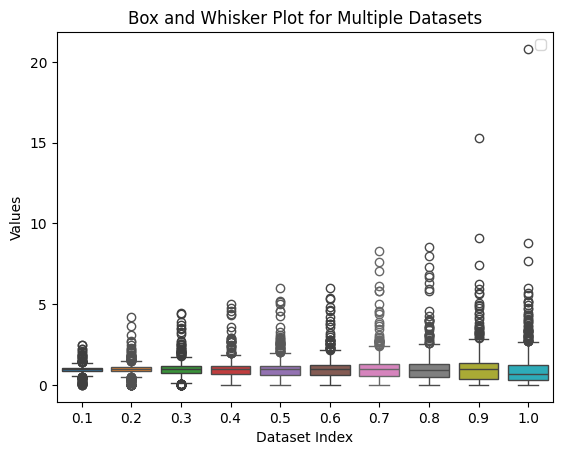

In [14]:
# Create a figure and axis
fig, ax = plt.subplots()

# Loop through each DataFrame in the list
for i, df in enumerate(cumulative_factors):
    # Plot the box and whisker plot for the current DataFrame
    sns.boxplot(x=(i+1)/10, y='Factors', data=df, ax=ax)

# Set labels and title
ax.set_xlabel('Dataset Index')
ax.set_ylabel('Values')
ax.set_title('Box and Whisker Plot for Multiple Datasets')

# Add legend
ax.legend()

# Show the plot
plt.show()

In [15]:
statistics = [odme.get_all_statistics() for odme in all_odme]

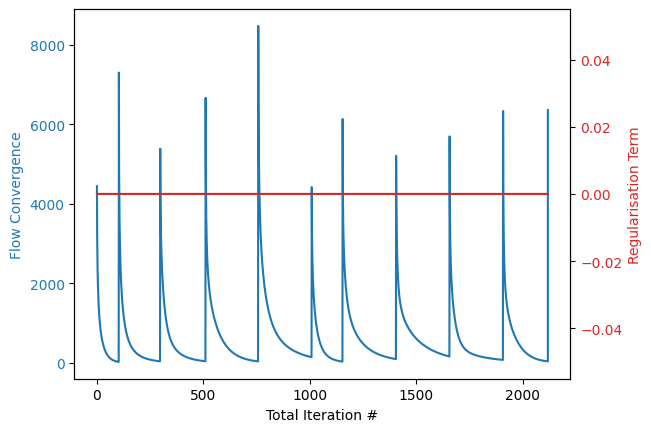

In [16]:
stats_spiess = statistics[9]
# Plot the first set of data
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Total Iteration #')
ax1.set_ylabel('Flow Convergence', color=color)
ax1.plot(stats_spiess["Total Iteration #"], stats_spiess["Flow Objective"].apply(lambda x: x**0.5), color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a twin Axes sharing the x-axis
ax2 = ax1.twinx()

color = 'tab:red'
ax2.set_ylabel('Regularisation Term', color=color)
ax2.plot(stats_spiess["Total Iteration #"], stats_spiess["Reg Objective"].apply(lambda x: x**0.5), color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Show the plot
plt.show()

<Axes: xlabel='Total Iteration #', ylabel='Convergence'>

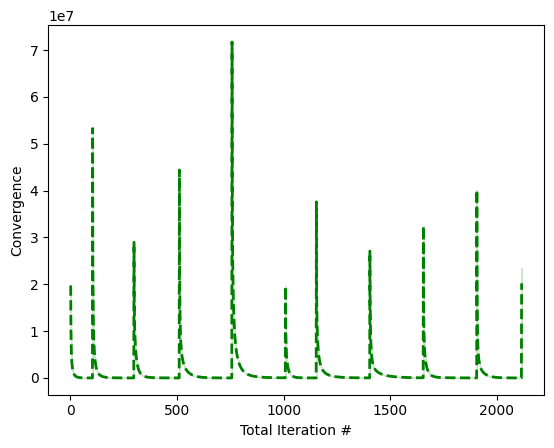

In [17]:
sns.lineplot(x='Total Iteration #', y='Convergence', data=stats_spiess, color='green', linestyle='--', linewidth=2)

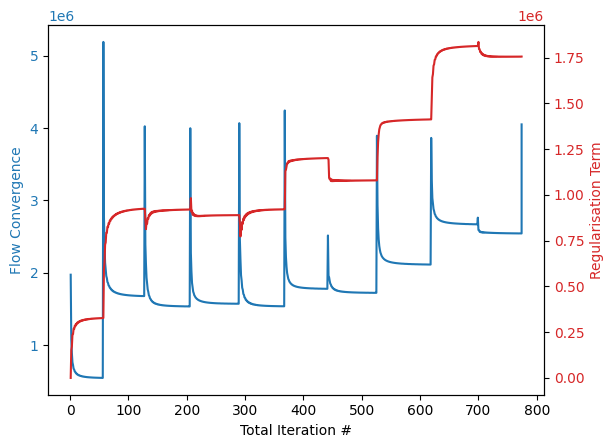

In [18]:
stats_regsp = statistics[0]
# Plot the first set of data
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Total Iteration #')
ax1.set_ylabel('Flow Convergence', color=color)
#ax1.plot(stats_regsp["Total Iteration #"], stats_regsp["Flow Objective"].apply(lambda x: x**0.5), color=color)
ax1.plot(stats_regsp["Total Iteration #"], stats_regsp["Flow Objective"], color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Create a twin Axes sharing the x-axis
ax2 = ax1.twinx()

color = 'tab:red'
ax2.set_ylabel('Regularisation Term', color=color)
#ax2.plot(stats_regsp["Total Iteration #"], stats_regsp["Reg Objective"].apply(lambda x: x**0.5), color=color)
ax2.plot(stats_regsp["Total Iteration #"], stats_regsp["Reg Objective"], color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Show the plot
plt.show()

<Axes: xlabel='Total Iteration #', ylabel='Convergence'>

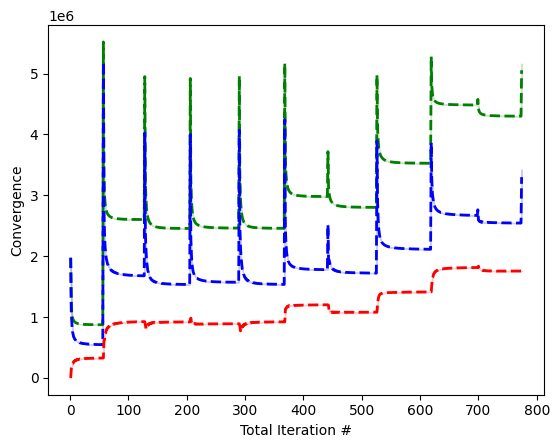

In [19]:
sns.lineplot(x='Total Iteration #', y='Convergence', data=stats_regsp, color='green', linestyle='--', linewidth=2)
sns.lineplot(x='Total Iteration #', y='Flow Objective', data=stats_regsp, color='blue', linestyle='--', linewidth=2)
sns.lineplot(x='Total Iteration #', y='Reg Objective', data=stats_regsp, color='red', linestyle='--', linewidth=2)